In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44925")
client

<Client: 'tcp://127.0.0.1:44925' processes=8 threads=32, memory=125.89 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:44343' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [6]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [7]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

ntheta = 36

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (nmemb: 48, freq_r: 17)>
array([[ 9.04585828e-08,  1.55943539e-08, -1.14760054e-09,
         8.36041421e-10,  5.97815928e-10,  1.55976990e-10,
         1.32256186e-10,  7.86137108e-11,  3.03983359e-11,
         9.36230276e-12,  1.18132367e-12, -2.72768374e-12,
        -3.45232686e-12, -3.35086869e-12, -2.84809570e-12,
        -2.02233427e-12, -1.13775595e-12],
       [ 8.94145998e-08,  2.48322119e-08,  5.68064793e-09,
         2.29494600e-09,  7.70674714e-10,  2.50080203e-10,
         2.15674850e-10,  1.02139844e-10,  5.31070388e-11,
         1.41555535e-11,  1.60272243e-12, -9.15806681e-13,
        -4.57571902e-13, -2.71414356e-13, -6.60952781e-14,
        -8.33239138e-14, -4.76278272e-14],
       [-4.81317634e-08,  8.28649701e-09,  3.86425279e-09,
         2.52202218e-09,  1.33981408e-09,  3.63597629e-10,
         2.29509439e-10,  1.68360520e-10,  9.26992052e-11,
         5.13904325e-11,  3.26371482e-11,  1.56505042e-11,
         6.50494235e-12,  2.19550279e-12,  7.

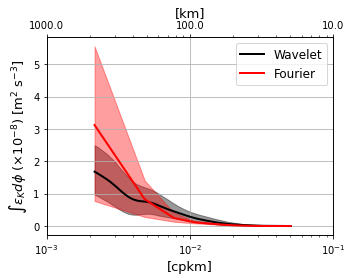

In [8]:
nz = 1

for reg in range(len(xs)-5):
    ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
    ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
    ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    # ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    MtE = (ds4.iso_uA + ds4.iso_vA)
    
    Ak = (ds0.iso_uA + ds1.iso_vA
          - MtE
         ).isel(Z=nz)
    # MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
    #         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
    #        )
    # Ak = (ds0.iso_uA + ds1.iso_vA
    #       # - (ds4.iso_uA + ds4.iso_vA)
    #       - MtE
    #      )
    piw = ((Ak) * dks).sum('angle').cumsum('scale').compute() * np.diff(ds0.angle)[0]*2
    datas = (piw, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
    
    ds0f = xr.open_dataset(op.join(savedir,'crossFourierDiags_u_region%02d_1967-01-01.zarr' % reg))
    ds1f = xr.open_dataset(op.join(savedir,'crossFourierDiags_v_region%02d_1967-01-01.zarr' % reg))
    ds4f = xr.open_dataset(op.join(savedir,'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    # ds4f = xr.open_dataset(op.join(savedir,'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
    MtE = (ds4f.MtEu + ds4f.MtEv)
    Ak = (ds0f.cs_uA + ds1f.cs_vA
          - MtE
         ).isel(Z=nz)
    # MtE = -(ds4f.upupUx + ds4f.vpupUy + ds4f.wpupUz
    #         + ds4f.upvpVx + ds4f.vpvpVy + ds4f.wpvpVz
    #        )
    iso_cs = xrft.isotropize(
        # (ds0f.cs_uA + ds1f.cs_vA
        #                       # - (ds4f.MtEu + ds4f.MtEv)
        #                       - MtE
        #                      )
        Ak.real, 
                             ["freq_YC","freq_XC"], truncate=True).compute() * 2*np.pi
    pif = (iso_cs*np.abs(np.diff(iso_cs.freq_r)[0])
          )[...,::-1].cumsum('freq_r')[...,::-1].compute()
    datas = (pif, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pfres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng)
    print(pif)
    
    
    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Pwres.confidence_interval.low*1e8, Pwres.confidence_interval.high*1e8, 
                    alpha=.4, color='k')
    ax.fill_between(iso_cs.freq_r*1e3, Pfres.confidence_interval.low*1e8, Pfres.confidence_interval.high*1e8, 
                    alpha=.38, color='r')
    
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=0,Z=0).mean(['nmemb'])*1e8,
    #         'r', lw=2, label=r"Zonal")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=len(piw.angle)//2,Z=0).mean(['nmemb'])*1e8,
    #         'c', lw=2, label=r"Meridional")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(Z=0).mean(['nmemb','angle'])*1e8,
    #         'k', lw=2, label=r"Isotropic")
    ax.plot((ds0.scale)**-1*1e3, piw.mean(['nmemb'])*1e8,
            'k', lw=2, label=r"Wavelet")
    ax.plot(iso_cs.freq_r*1e3, pif.mean(['nmemb'])*1e8,
            'r', lw=2, label=r"Fourier")
    
    ax.set_xscale('log')
#             ax.set_yscale('log')
    # ax2.set_xscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # if reg < 5:
    #     ax.set_ylim([-np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e8*.9),
    #                  np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e8*.9)])
    #     # ax2.set_ylim([-np.abs(pif.isel(Z=0,freq_r=0)*1e8*.9),
    #     #               np.abs(pif.isel(Z=0,freq_r=0)*1e8*.9)])
    # else:
    #     ax.set_ylim([-np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e8*.9,
    #                  np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e8*.9])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    # ax2.set_ylim([-.3,1])
    # ax2.spines['right'].set_color('b')
    # ax2.yaxis.label.set_color('b')
    # ax2.tick_params(axis='y', colors='b')
    # ax.set_ylabel(r"$\epsilon_K$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
    ax.set_ylabel(r"$\int\epsilon_Kd\phi$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
    # ax2.set_ylabel(r"$\hat{\epsilon}$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13, c='b')
    ax.grid(True)
    if reg == 0:
        # ax.legend(loc='lower left', fontsize=12)
        ax.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(savedir,'Figs/WvsF_KE-specflux_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,'Figs/WvsF_KE-specflux_reenvisioned_Region%02d_Z452.pdf' % reg))
    plt.show()

In [19]:
reg = 0
ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
# ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
# MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
#         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
#        )
# Ak = (ds0.iso_uA + ds1.iso_vA
#           # - (ds4.iso_uA + ds4.iso_vA)
#       - MtE
#      )
MtE = (ds4.iso_uA + ds4.iso_vA)
    
Ak = (ds0.iso_uA + ds1.iso_vA
      - MtE
     )
piw = ((Ak) * dks).cumsum('scale').compute()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


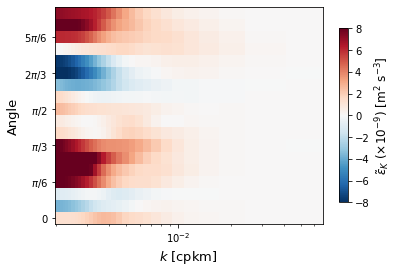

In [20]:
values = np.array([8,3,2.,.1,.06,.06])

fig, ax = plt.subplots()
im = ax.pcolormesh((piw.scale)**-1*1e3, piw.angle, piw.isel(Z=1).mean('nmemb')*1e9,
                   vmax=values[reg], vmin=-values[reg],
                   cmap='RdBu_r', rasterized=True
                  )
ax.set_xscale('log')
ax.set_xlabel(r"$k$ [cpkm]", fontsize=13)
ax.set_ylabel(r"Angle", fontsize=13)
ax.set_yticks([piw.angle[0], piw.angle[3], piw.angle[6], piw.angle[9], piw.angle[12], piw.angle[15]])
ax.set_yticklabels(['0', r"$\pi/6$", r"$\pi/3$", r"$\pi/2$", r"$2\pi/3$", r"$5\pi/6$"])
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"$\tilde{\epsilon}_K$ ($\times 10^{-9}$) [m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figs/KE-specflux_Region%02d_phi-K_Z452.pdf' % reg))
# plt.savefig(op.join(savedir,'Figs/KE-specflux_reenvisioned_Region%02d_phi-K_Z452.pdf' % reg))